# Statistical Analysis & Visualization

This notebook performs statistical analysis on the results of different optimization algorithms (NSGA-II, GA, \u03bc+\u03bb, SA) applied to the hospital path planning problem.

**Objective:** Determine if the observed differences in performance are statistically significant or due to random chance (luck).

**Methodology:**
- **Data Source:** `results/combined/all_algorithms_combined.csv`
- **Primary Metric:** `best_fitness` (Penalized Cost). This is the correct metric for comparison because it accounts for solution validity (collisions, constraints). Comparing 'clean distance' is unfair if some algorithms return invalid solutions with artificially low distances.
- **Tests:** 
    - Normality check (Shapiro-Wilk)
    - Significance test (Kruskal-Wallis / ANOVA)
    - Post-hoc pairwise comparison (Dunn's test)
    - 95% Confidence Intervals (Bootstrap/T-dist)

## 1. Import Libraries

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp
import matplotlib.patheffects as path_effects

# Ensure output directories exist
os.makedirs('../plots/comparative', exist_ok=True)
os.makedirs('../validation_report', exist_ok=True)

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported and directories checked.")

Libraries imported and directories checked.


## 2. Load Data (From DB - Legacy/Optional)
*This section is kept for compatibility but main analysis uses CSVs below.*

In [12]:
import sqlite3

def load_from_db(db_path, algo_name):
    try:
        if os.path.exists(db_path):
            con = sqlite3.connect(db_path)
            df = pd.read_sql_query("SELECT * FROM runs", con)
            con.close()
            df['algorithm'] = algo_name
            return df
        return None
    except Exception as e:
        print(f"Error loading {algo_name}: {e}")
        return None

# Attempt to load from DBs (just to print status)
db_files = {
    'NSGA-II': '../data/nsga2_experiments.db',
    'GA': '../data/ga_experiments.db',
    'μ+λ': '../data/mulambda_experiments.db',
    'SA': '../data/sa_experiments.db'
}

for algo, path in db_files.items():
    df_tmp = load_from_db(path, algo)
    if df_tmp is not None:
        print(f"DB found for {algo}: {len(df_tmp)} records")
    else:
        print(f"DB NOT found for {algo}")

DB found for NSGA-II: 31 records
DB found for GA: 31 records
DB found for μ+λ: 31 records
DB found for SA: 31 records


## 3. Load Data from CSV (Primary Source)
We load the combined results containing `best_clean` for all algorithms. This ensures we compare exactly the same metric.

In [13]:
CSV_PATH = '../results/combined/all_algorithms_combined.csv'

if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    print(f"Loaded data from {CSV_PATH}")
    print(f"Total runs: {len(df)}")
    print("\nAlgorithms found:")
    print(df['algorithm'].value_counts())
    
    # Preview
    print("\nData Preview:")
    print(df.head())
else:
    raise FileNotFoundError(f"CRITICAL: Results file not found at {CSV_PATH}. Please run experiments first.")

Loaded data from ../results/combined/all_algorithms_combined.csv
Total runs: 124

Algorithms found:
algorithm
NSGA-II    31
GA         31
μ+λ        31
SA         31
Name: count, dtype: int64

Data Preview:
  algorithm  best_fitness   best_clean    time_sec
0   NSGA-II   1103.193001  1085.193001  386.591481
1   NSGA-II   1175.429797  1100.979797  393.946214
2   NSGA-II   1237.785642  1161.435642  394.148334
3   NSGA-II   1134.144011  1103.394011  394.777181
4   NSGA-II   1150.435137  1129.335137  395.162473


## 4. Statistical Confidence Analysis

We calculate the **95% Confidence Interval** for the mean `best_fitness` (Penalized Cost). 
- **Narrow interval:** High confidence in the result (consistent performance).
- **Wide interval:** Low confidence (results depend heavily on "luck"/seed).

In [14]:
def get_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

comparison_metric = 'best_fitness'

stats_summary = []

print(f"--- Confidence Analysis (Metric: {comparison_metric}) ---\n")

for algo in df['algorithm'].unique():
    subset = df[df['algorithm'] == algo][comparison_metric]
    mean_val, lower, upper, margin = get_confidence_interval(subset)
    std_val = subset.std()
    min_val = subset.min()
    
    stats_summary.append({
        'Algorithm': algo,
        'Mean': mean_val,
        'Std': std_val,
        'CI_Lower': lower,
        'CI_Upper': upper,
        'Margin': margin,
        'Best_Seen': min_val,
        'Samples': len(subset)
    })
    
    print(f"Algorithm: {algo:8s} | Mean: {mean_val:.2f} ± {margin:.2f} (95% CI: [{lower:.2f}, {upper:.2f}]) | Best: {min_val:.2f}")

summary_df = pd.DataFrame(stats_summary).sort_values('Mean')

# Save summary for paper
summary_csv_path = '../validation_report/statistical_confidence_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)
print(f"\nSummary saved to: {summary_csv_path}")

--- Confidence Analysis (Metric: best_fitness) ---

Algorithm: NSGA-II  | Mean: 1227.07 ± 41.45 (95% CI: [1185.62, 1268.53]) | Best: 1084.98
Algorithm: GA       | Mean: 1311.74 ± 58.73 (95% CI: [1253.01, 1370.47]) | Best: 1123.09
Algorithm: μ+λ      | Mean: 1294.01 ± 42.55 (95% CI: [1251.47, 1336.56]) | Best: 1104.66
Algorithm: SA       | Mean: 2135.03 ± 105.71 (95% CI: [2029.32, 2240.74]) | Best: 1668.14

Summary saved to: ../validation_report/statistical_confidence_summary.csv


### Interpretation of Luck vs Performance

We calculate the **Coefficient of Variation (CV)** to quantify "luck":
- $CV = \frac{\sigma}{\mu} \times 100\%$
- Higher CV = Results vary wildly with seed = High dependence on luck.

  Algorithm         Mean         Std     CV (%)    Best_Seen
0   NSGA-II  1227.073751  113.013700   9.210017  1084.979797
2       μ+λ  1294.012814  115.992690   8.963798  1104.658730
1        GA  1311.741928  160.116293  12.206387  1123.086147
3        SA  2135.029709  288.186522  13.498010  1668.135642


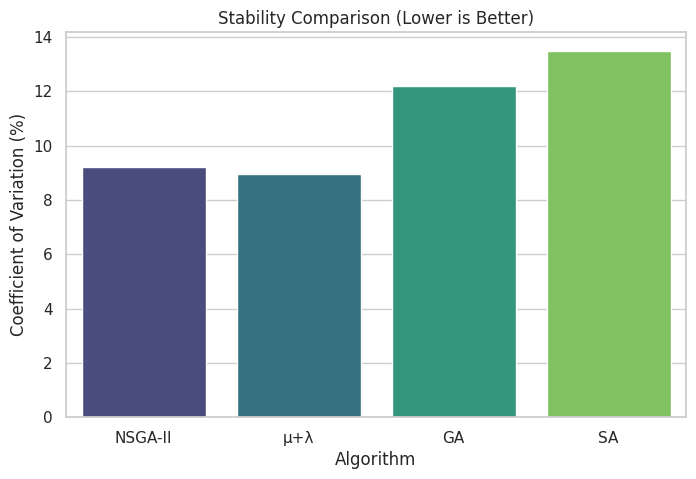

In [15]:
summary_df['CV (%)'] = (summary_df['Std'] / summary_df['Mean']) * 100
print(summary_df[['Algorithm', 'Mean', 'Std', 'CV (%)', 'Best_Seen']])

# Visualize CV
plt.figure(figsize=(8, 5))
sns.barplot(x='Algorithm', y='CV (%)', data=summary_df, hue='Algorithm', legend=False, palette='viridis')
plt.title('Stability Comparison (Lower is Better)')
plt.ylabel('Coefficient of Variation (%)')
plt.savefig('../plots/comparative/stability_cv.png')
plt.show()

## 5. Hypothesis Testing (Significance)

Is the best algorithm *significantly* better, or just lucky?

1. **Normality Test (Shapiro-Wilk):** Check if data follows normal distribution.
2. **Kruskal-Wallis Test:** Non-parametric ANOVA equivalent (since data is often not normal in GA).
3. **Dunn's Post-hoc:** Pairwise comparison to find exactly *which* algorithms differ.

--- Shapiro-Wilk Normality Test ---
NSGA-II : p=0.0001 (Not Normal)
GA      : p=0.0009 (Not Normal)
μ+λ     : p=0.3801 (Normal)
SA      : p=0.1545 (Normal)

Conclusion: Data is NOT consistently Normal. Using Non-Parametric tests.

--- Kruskal-Wallis Test ---
H-statistic: 73.32, p-value: 8.2880e-16
RESULT: Significant difference found among algorithms (p < 0.05).

--- Post-hoc Dunn's Test (Pairwise) ---
                   GA       NSGA-II            SA           μ+λ
GA       1.000000e+00  5.193470e-01  2.233520e-09  1.000000e+00
NSGA-II  5.193470e-01  1.000000e+00  8.845618e-15  3.636093e-01
SA       2.233520e-09  8.845618e-15  1.000000e+00  6.257904e-09
μ+λ      1.000000e+00  3.636093e-01  6.257904e-09  1.000000e+00


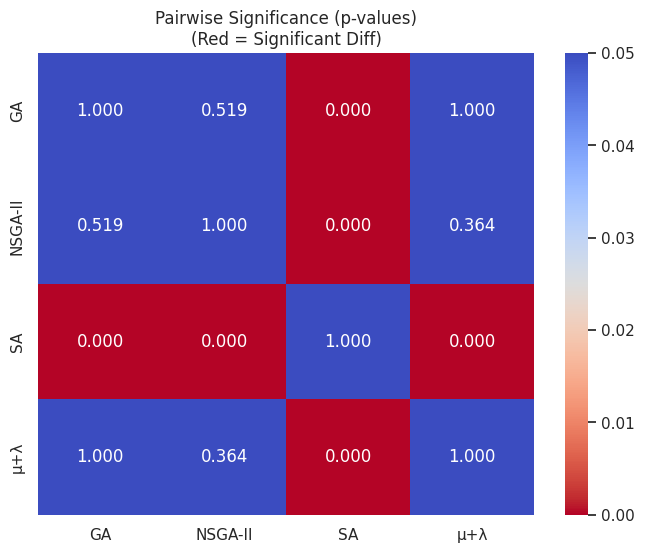

In [16]:
# 1. Normality
print("--- Shapiro-Wilk Normality Test ---")
parametrics_ok = True
for algo in df['algorithm'].unique():
    stat, p = stats.shapiro(df[df['algorithm'] == algo][comparison_metric])
    print(f"{algo:8s}: p={p:.4f} ({'Normal' if p > 0.05 else 'Not Normal'})")
    if p < 0.05: parametrics_ok = False

print(f"\nConclusion: Data is {'Normal' if parametrics_ok else 'NOT consistently Normal'}. Using Non-Parametric tests.")

# 2. Kruskal-Wallis
groups = [df[df['algorithm'] == a][comparison_metric] for a in df['algorithm'].unique()]
stat, p_kw = stats.kruskal(*groups)

print(f"\n--- Kruskal-Wallis Test ---")
print(f"H-statistic: {stat:.2f}, p-value: {p_kw:.4e}")
if p_kw < 0.05:
    print("RESULT: Significant difference found among algorithms (p < 0.05).")
    
    # 3. Post-hoc Dunn's Test
    print("\n--- Post-hoc Dunn's Test (Pairwise) ---")
    dunn = sp.posthoc_dunn(df, val_col=comparison_metric, group_col='algorithm', p_adjust='bonferroni')
    print(dunn)
    
    # Save heatmap of p-values
    plt.figure(figsize=(8, 6))
    sns.heatmap(dunn, annot=True, cmap='coolwarm_r', fmt='.3f', vmin=0, vmax=0.05)
    plt.title('Pairwise Significance (p-values)\n(Red = Significant Diff)')
    plt.savefig('../plots/comparative/significance_heatmap.png')
    plt.show()
else:
    print("RESULT: No significant difference found. Any observed difference is likely random noise.")

## 6. Comparative Visualizations

Visualizing the distributions to verify the statistical findings.

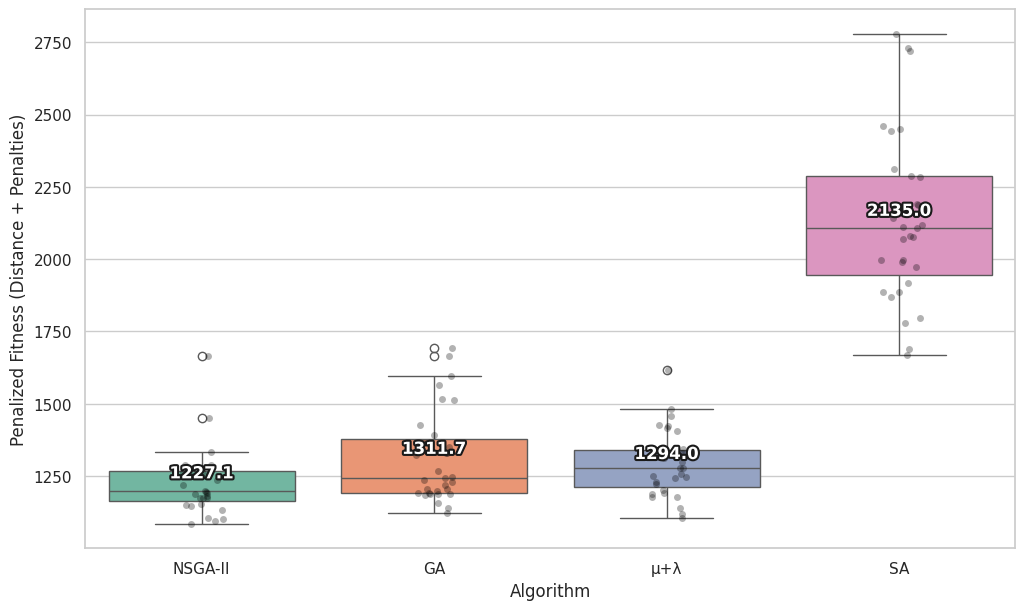

In [18]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='algorithm', y=comparison_metric, data=df, hue='algorithm', legend=False, palette='Set2')
sns.stripplot(x='algorithm', y=comparison_metric, data=df, color='black', alpha=0.3, jitter=True)

#plt.title(f'Comparison of {comparison_metric} (Lower is Better)')
plt.ylabel('Penalized Fitness (Distance + Penalties)')
plt.xlabel('Algorithm')

# Add mean values as labels
means = df.groupby(['algorithm'])[comparison_metric].mean()
vertical_offset = df[comparison_metric].mean() * 0.01

ax = plt.gca()
xticks = ax.get_xticks()
labels = [l.get_text() for l in ax.get_xticklabels()]

for i, label in enumerate(labels):
    if label in means.index:
        val = means[label]
        ax.text(xticks[i], val + vertical_offset, f'{val:.1f}', 
                 horizontalalignment='center', color='w', weight='bold', 
                 path_effects=[path_effects.withStroke(linewidth=3, foreground='k')])

plt.savefig('../plots/comparative/boxplot_best_fitness.png')
plt.show()

## 7. Generate Paper Report

Auto-generating a LaTeX table snippet for the paper.

In [ ]:
latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|l|c|c|c|}\n\\hline\n"
latex_table += "Algorithm & Mean Penalized Cost (95\\% CI) & Best Observed & Stability (CV) \\\\\n\\hline\n"

for _, row in summary_df.iterrows():
    ci_str = f"[{row['CI_Lower']:.1f}, {row['CI_Upper']:.1f}]"
    latex_table += f"{row['Algorithm']} & {row['Mean']:.1f} $\\pm$ {row['Margin']:.1f} & {row['Best_Seen']:.1f} & {row['CV (%)']:.1f}\\% \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Statistical comparison of penalized fitness (validity-aware) across 30 runs.}\n\\label{tab:alg_comparison}\n\\end{table}"

with open('../validation_report/table_results.tex', 'w') as f:
    f.write(latex_table)

print("LaTeX table generated at: ../validation_report/table_results.tex")
print(latex_table)